# GFS Forecast Maps from Thredds Server via NCSS and Siphon
# 6-Hour Precip Accumulation

## Justin Richling
## 11/15/18

https://doi.org/10.6084/m9.figshare.5244637.v1

In [ ]:
# Random Library Imports
import subprocess,os,glob,tempfile,re,webbrowser,io,sys,types,\
time

# Importing Datetime Libraries
from datetime import datetime, timedelta

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj 

# Numerical and Scientific Libraries
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

# Accessing Data from External Databases via XLM Catalog
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog

# MetPy Libraries
import metpy
import metpy.calc as mpcalc
from metpy.units import masked_array, units
from metpy.plots import ctables
from metpy.plots import add_metpy_logo
from metpy.constants import g

# NetCDF Libraries
from netCDF4 import Dataset
from netCDF4 import num2date

# More Image Manipulation Options
from PIL import Image as PILImage
from IPython.display import Image

# Ipyhton Options
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML, display, Image

# Matplotlib Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LinearSegmentedColormap

# Warnings
import warnings
warnings.filterwarnings('ignore')

#import ColorBar


## Helper Functions

In [2]:
# Thanks to the crew over at Metpy for this handy little function
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set the Map Projection

In [3]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')

# Colorbar Axis Placement (under figure)
colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]

# Lat/Lon Extents [lon0,lon1,lat0,lat1]
extent = [-130., -70, 20., 60.]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set a list for the 24 hour forecast time steps

In [4]:
now = datetime.utcnow()
#now = datetime(2019,2,7,18,0)
today_day = int('{0:%d}'.format(now))
today_year = int('{0:%Y}'.format(now))
today_month = int('{0:%m}'.format(now))
print(today_day,today_year,today_month)

forecast_times = []
forecast_times.append(now)
#for i in range(4,8):
#    forecast_times.append(datetime(today_year,today_month,today_day,i*3,0))
#for i in range(0,5):
#    forecast_times.append(datetime(today_year,today_month,today_day+1,i*3,0))
forecast_times

12 2019 3


[datetime.datetime(2019, 3, 12, 20, 6, 38, 756160)]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Figure out where the saved maps will go

In [ ]:
# Set a path to save the plots with string format for the date to set the month and day 
im_save_path ="/path/to/saved/images/"
print(im_save_path)

# Check to see if the folder already exists, if not create it
if not os.path.isdir(im_save_path):
    os.makedirs(im_save_path)

# Uncomment if you want to automatically change to the map folder    
#os.chdir(im_save_path)

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Start at the top of the thredds catalog

In [6]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref_anl = top_cat.catalog_refs['Forecast Products and Analyses']
new_cat_anl = ref_anl.follow()
model_anl = new_cat_anl.catalog_refs[1]
gfs_anl_cat = model_anl.follow()
ds_anl = gfs_anl_cat.datasets[1]
print("Variable Name:",ds_anl.name)
print("Path:",ds_anl.url_path)

Variable Name: Best National Weather Service CONUS Forecast Grids (CONDUIT) Time Series
Path: grib/NCEP/NDFD/NWS/CONUS/CONDUIT/Best


<h2>----------------------------------------------//---------------------------------------------------------</h2>
<h2>----------------------------------------------//---------------------------------------------------------</h2>

<h1><font><center>-- 6-Hour Precipitation Accumulation --</center></font></h1>

* Starting at??

2019_03_12_18Z


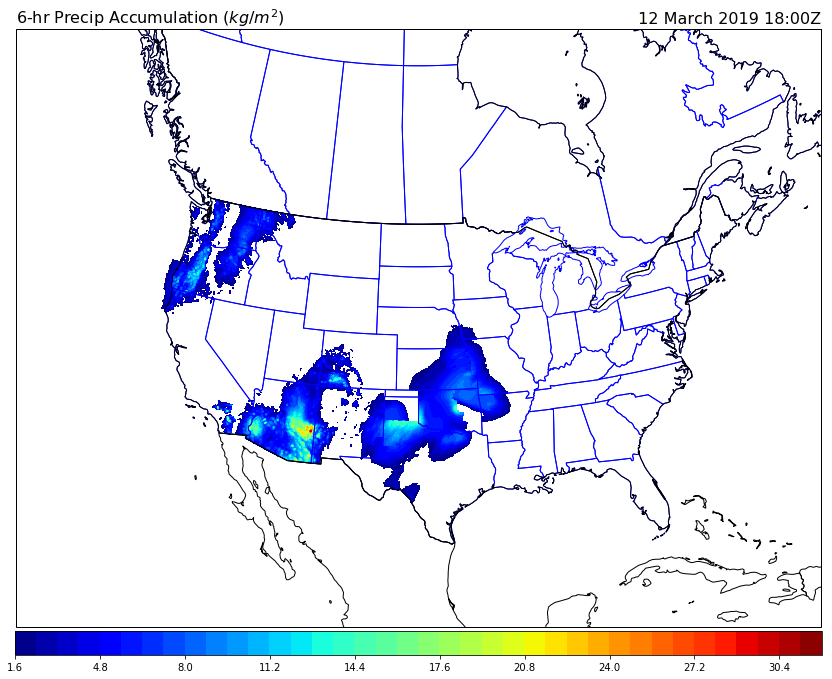

done.


In [9]:
for i in forecast_times:

    subset = ds_anl.subset()
    query_data = subset.query()
    query_data.lonlat_box(west=-130, east=-50, south=10, north=60)

        # Allow for NetCDF files
    query_data.accept('netcdf4')
    query_data.time(i)
    data = query_data.variables("Total_precipitation_surface_6_Hour_Accumulation").add_lonlat()

        # Finally attempt to access the data
    data = subset.get_data(query_data)
    dew = data.variables['Total_precipitation_surface_6_Hour_Accumulation'][:].squeeze()
    dew = np.ma.masked_where(dew < 2.,dew)

    lat = data.variables['lat'][:].squeeze()
    lon = data.variables['lon'][:].squeeze()
            #lats = data.variables['lat'][:]
            #lons = data.variables['lon'][:]
    time_var = data.variables[find_time_var(data.variables['Total_precipitation_surface_6_Hour_Accumulation'])]

        # Convert number of hours since the reference time into an actual date
    time_final = num2date(time_var[:].squeeze(), time_var.units)
    print(str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z")
    file_time = str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z"

            # Create new figure
    fig = plt.figure(figsize=(17., 11.))

    add_metpy_logo(fig, 30, 1000, size='small')

        # Add the map and set the extent
    ax = plt.subplot(111, projection=plotcrs)

        #Set the lat and lon boundaries
    ax.set_extent(extent, datacrs)

        # Add state boundaries to plot
    ax.add_feature(states_provinces, edgecolor='blue', linewidth=1)

        # Add country borders to plot
    ax.add_feature(country_borders, edgecolor='black', linewidth=1)

    # Plot Title
    plt.title('6-hr Precip Accumulation ($kg/m^{2}$)',loc='left',fontsize=16)
    plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final),loc='right',fontsize=16)

    cs = ax.contourf(lon,lat,dew,40, cmap="jet",transform=datacrs)#norm=Normalize(-1, 80)
    cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]
    cbar = plt.colorbar(cs, orientation='horizontal',cax=cbaxes)
    #cbar.set_label(r'$s^-1$')

    plt.show()
    #---------------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------------
    PV_Jet = im_save_path+"GFS/Precip_6/"
    if not os.path.isdir(PV_Jet):
        os.makedirs(PV_Jet)
    fig.savefig(PV_Jet+"Precip_Accum"+file_time+".png",
                bbox_inches='tight',dpi=120)
    plt.close(fig)
print('done.')